In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import pickle

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap, bar_chart
from moge.network.edge_generator import DataGenerator
from moge.visualization.visualize_embedding import visualize_embedding, plot_bokeh_graph

# from bokeh.io import output_notebook
# output_notebook()

Using TensorFlow backend.


#  Import network from file

In [2]:
with open('moge/data/luad_data_multi_U-T.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    


In [3]:
from moge.network.heterogeneous_network import get_rename_dict
noncode_rename_dict = pd.Series(luad_data.LNC.noncode_func_df["Gene Name"].values,
     index=luad_data.LNC.noncode_func_df["NONCODE Gene ID"].str.split(".", expand=True)[0]).to_dict()
noncode_rename_dict = {k: noncode_rename_dict[k] for k in noncode_rename_dict if type(noncode_rename_dict[k])!=float}

lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")
lncbase_rename_dict.update(noncode_rename_dict)

In [4]:
# READ
# with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.train.pickle', 'rb') as file:
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.latest.pickle', 'rb') as file:
    network = pickle.load(file)
    network.preprocess_graph()
    network.process_genes_info()
    network.multi_omics_data = luad_data
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 58980
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [29]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.test_v2.pickle', 'rb') as file:
    network_val = pickle.load(file)
    network_val.preprocess_graph()
    network_val.process_genes_info()
    network_val.multi_omics_data = luad_data

network_val.G.remove_edges_from([(u,v,d) for u,v,d in network_val.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])
network_val.G = nx.relabel_nodes(network_val.G, lncbase_rename_dict)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 58986
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [6]:
# with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
#     luad_data = pickle.load(file)
#     network.multi_omics_data = luad_data
#     network.process_genes_info()

In [7]:
network.genes_info["Transcript length"] = network.genes_info["Transcript sequence"].apply(lambda x: len(x) if type(x) == str else None)
network.genes_info["Transcript length"].describe(percentiles=[.50, .75, .85, .90, .95, .99])

count    32741.000000
mean       791.396109
std       1132.424500
min         41.000000
50%        518.000000
75%        726.000000
85%       1112.000000
90%       1697.000000
95%       2553.000000
99%       5047.600000
max      91667.000000
Name: Transcript length, dtype: float64

# Data Visualization

In [8]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [9]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

In [10]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

In [11]:
# The test data to recall
# matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [12]:
params = {
    'weighted': True,
 
 'truncating': 'random',
 'source_target_dense_layers': True,
 'negative_sampling_ratio': 5.0,
 'max_length': 5050,
 'max2_pool_size': 6,
 'max1_pool_size': 9,
 'margin': 1.0,
 'lstm_unit_size': 320,
 'lr': 0.0005,
 'embedding_normalization': False,
 'directed_proba': 1.0,
    'directed_distance': 'dot_sigmoid',
    'undirected_distance': 'dot_softmax',
 'dense2_unit_size': None,
 'dense1_unit_size': 512,
 'd': 128,
 'conv2_kernel_size': 6,
 'conv2_batch_norm': True,
 'conv1_kernel_size': 6,
 'conv1_batch_norm': True,
 'compression_func': 'sqrt3'}


In [13]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
from moge.embedding.siamese_triplet_online_embedding import SiameseOnlineTripletGraphEmbedding

siamese = SiameseOnlineTripletGraphEmbedding(batch_size=225, margin=params["margin"], epochs=200, verbose=True)
# siamese = SiameseGraphEmbedding(batch_size=425, epochs=10, verbose=True)

# siamese = SiameseTripletGraphEmbedding(d=128, batch_size=256, margin=0.2, lr=0.001, epochs=30, 
#     negative_sampling_ratio=2.0, directed_proba=0.8, compression_func="sqrt3",
#     max_length=2000, truncating="post", verbose=True)

siamese.set_params(**params)

directed_margin 1.0 , undirected_margin 1.0


SiameseOnlineTripletGraphEmbedding(batch_size=225, compression_func='sqrt3',
                  conv1_batch_norm=True, conv1_kernel_size=6,
                  conv2_batch_norm=True, conv2_kernel_size=6, d=128,
                  dense1_unit_size=512, dense2_unit_size=None,
                  directed_distance='dot_sigmoid', directed_proba=1.0,
                  embedding_normalization=False, epochs=200, lr=0.0005,
                  lstm_unit_size=320, margin=1.0, max1_pool_size=9,
                  max2_pool_size=6, max_length=5050,
                  negative_sampling_ratio=5.0, seed=0,
                  source_target_dense_layers=True, truncating='random',
                  undirected_distance='dot_softmax', verbose=True,
                  weighted=True)

In [14]:
# import yaml
# with open("logs/SiameseGraphEmbeddin_03-29_11-50PM/params.txt", "r") as file:
#     params = yaml.load(str(file.read()))
#     params["subsample"] = False
# #     params["batch_size"] = 105
#     siamese.set_params(**params)
#     file.close()
    
# siamese.load_model("logs/SiameseGraphEmbeddin_03-29_11-50PM/lstm_model.e5.h5", network)

In [15]:
siamese.learn_embedding(network, network_val=network_val, 
                        multi_gpu=False, rebuild_model=False,
                        n_steps=2000, 
                        validation_steps=250,
                        tensorboard=True,
                        early_stopping=0,
                        initial_epoch=100,
                        seed=0),

word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}
# of nodes to sample from (non-zero degree): 31623
# of nodes to sample from (non-zero degree): 4113
labels_directed SparseTensor(indices=Tensor("labels_directed/indices:0", shape=(?, 2), dtype=int64, device=/device:GPU:0), values=Tensor("labels_directed/values:0", shape=(?,), dtype=float32, device=/device:GPU:0), dense_shape=Tensor("labels_directed/shape:0", shape=(2,), dtype=int64, device=/device:GPU:0))
labels_undirected SparseTensor(indices=Tensor("labels_undirected/indices:0", shape=(?, 2), dtype=int64, device=/device:GPU:0), values=Tensor("labels_undirected/values:0", shape=(?,), dtype=float32, device=/device:GPU:0), dense_shape=Tensor("labels_undirected/shape:0", shape=(2,), dtype=int64, device=/device:GPU:0))
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:GPU:0)
conv2D Tensor("lstm_lambda_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
conv1d_2 Tensor("

Epoch 36/200
1000/1000 [==============================] - 300s 300ms/step - loss: 0.1892 - _precision: 0.8287 - _recall: 0.7321 - val_loss: nan - val__precision: 0.8869 - val__recall: 0.1837
Epoch 37/200
1000/1000 [==============================] - 299s 299ms/step - loss: 0.1880 - _precision: 0.8313 - _recall: 0.7374 - val_loss: nan - val__precision: 0.8846 - val__recall: 0.1627
Epoch 38/200
1000/1000 [==============================] - 299s 299ms/step - loss: 0.1869 - _precision: 0.8348 - _recall: 0.7397 - val_loss: nan - val__precision: 0.8510 - val__recall: 0.1220
Epoch 39/200
1000/1000 [==============================] - 300s 300ms/step - loss: 0.1853 - _precision: 0.8356 - _recall: 0.7463 - val_loss: nan - val__precision: 0.8564 - val__recall: 0.1110
Epoch 40/200
1000/1000 [==============================] - 300s 300ms/step - loss: 0.1841 - _precision: 0.8393 - _recall: 0.7505 - val_loss: nan - val__precision: 0.8913 - val__recall: 0.1199
Epoch 41/200
1000/1000 [=====================

Epoch 76/200
1000/1000 [==============================] - 300s 300ms/step - loss: 0.1580 - _precision: 0.8964 - _recall: 0.8392 - val_loss: nan - val__precision: 0.8708 - val__recall: 0.2293
Epoch 77/200
1000/1000 [==============================] - 299s 299ms/step - loss: 0.1572 - _precision: 0.8973 - _recall: 0.8429 - val_loss: nan - val__precision: 0.8670 - val__recall: 0.2430
Epoch 78/200
1000/1000 [==============================] - 299s 299ms/step - loss: 0.1564 - _precision: 0.8973 - _recall: 0.8436 - val_loss: nan - val__precision: 0.8668 - val__recall: 0.1842
Epoch 79/200
1000/1000 [==============================] - 299s 299ms/step - loss: 0.1562 - _precision: 0.9003 - _recall: 0.8466 - val_loss: nan - val__precision: 0.8664 - val__recall: 0.2210
Epoch 80/200
1000/1000 [==============================] - 300s 300ms/step - loss: 0.1554 - _precision: 0.9011 - _recall: 0.8460 - val_loss: nan - val__precision: 0.8539 - val__recall: 0.2345
Epoch 81/200
1000/1000 [=====================

Process ForkPoolWorker-1723:
Process ForkPoolWorker-1738:
Process ForkPoolWorker-1728:
Process ForkPoolWorker-1727:
Process ForkPoolWorker-1742:
Process ForkPoolWorker-1744:
Process ForkPoolWorker-1726:
Process ForkPoolWorker-1737:
Process ForkPoolWorker-1721:
Process ForkPoolWorker-1743:
Process ForkPoolWorker-1740:
Process ForkPoolWorker-1739:
Process ForkPoolWorker-1725:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1722:
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1741:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1724:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (

  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/triplet_generator.py", line 125, in __getitem__
    X, y = self.__data_generation(sampled_nodes)
KeyboardInterrupt
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/lib/pyth

Stop training


(None,)

# Visualize Embeddings

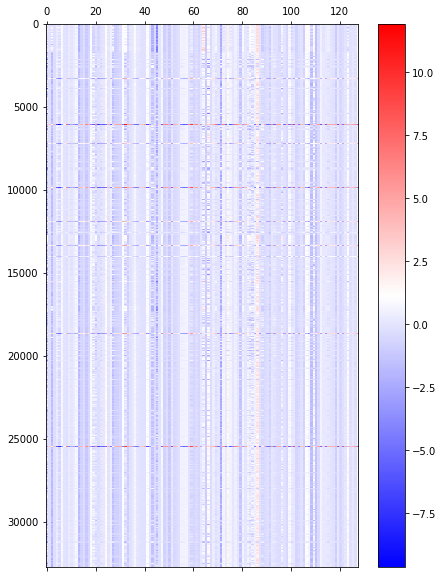

Process ForkPoolWorker-1747:
Process ForkPoolWorker-1752:
Process ForkPoolWorker-1748:
Process ForkPoolWorker-1751:
Process ForkPoolWorker-1745:
Traceback (most recent call last):
Process ForkPoolWorker-1746:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/o

In [16]:
matrix_heatmap(siamese.get_embedding(recompute=True), cmap="bwr", aspect='auto', figsize=(7,10))

Dot product & sigmoid


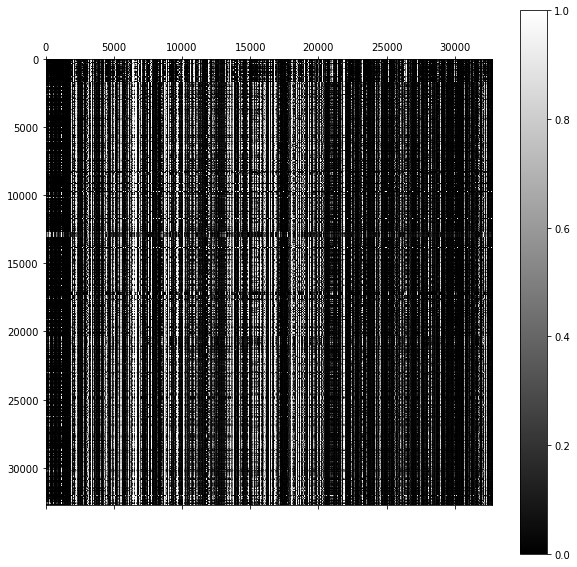

In [17]:
delattr(siamese, "reconstructed_adj") if hasattr(siamese, "reconstructed_adj") else None
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", 
#                                              interpolate=False,
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(),
                                            ), figsize=(10, 10))

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


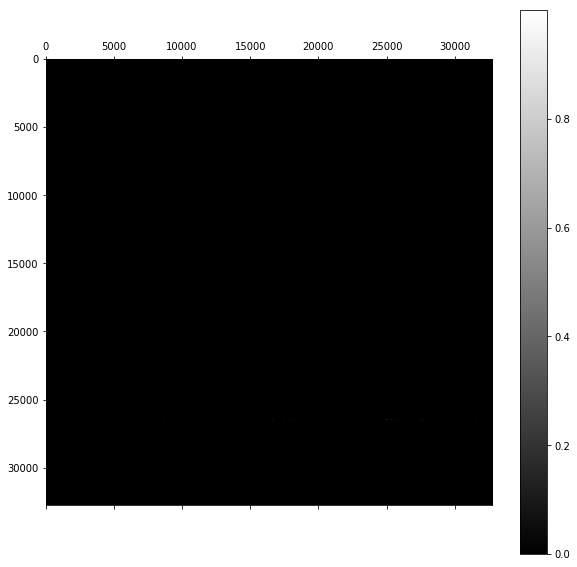

In [18]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(), 
                                             ), figsize=(10,10))

# Save Model & Embedding

In [ ]:
siamese.save_model("lstm_model.h5", model="lstm", logdir=True)

In [20]:
# siamese.truncating = "post"
# siamese.save_embeddings("lmn_train.triplet.shortest.biogrid.full.euclidean.trunc.emb", 
#                         variable_length=False, recompute=False, minlen=100)

In [21]:
siamese.log_dir

'logs/SiameseOnlineTriplet_04-23_ 1-51PM'

# Import different models

In [22]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
from moge.embedding.sequence_based_embedding import BioVecEmbedding, iDeepVEmbedding, LncTarInteraction

nodelist = network.genes_info.index.tolist()

# biovec_emb = BioVecEmbedding(network, {"MIR": "moge/data/biovec/miRNA_protvec.model",
#                          "GE": "moge/data/biovec/mRNA_protvec.model",
#                          "LNC": "moge/data/biovec/lncRNA_protvec.model"})

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=nodelist)


biovec_emb = ImportedGraphEmbedding(d=100, method_name="BioVec")
biovec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.biovec.emb", 
                          node_list=nodelist)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=nodelist)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=nodelist)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=nodelist)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)
rna2rna_emb.network = network

print()

node2vec imported (21355, 128)
BioVec imported (32707, 100)
LINE imported (21355, 128)
HOPE imported (21355, 128)
SDNE imported (21355, 128)
rna2rna imported (32697, 128)



In [23]:
# rna2rna_graph = nx.from_numpy_matrix(rna2rna_emb.get_reconstructed_adj(), create_using=nx.DiGraph())

In [24]:
# delattr(rna2rna_emb, "reconstructed_adj") if hasattr(rna2rna_emb, "reconstructed_adj") else None
# matrix_heatmap(rna2rna_emb.get_reconstructed_adj())

In [25]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
# methods["rna2rna"] = rna2rna_emb
methods["rna2rna"] = siamese

# Prepare Validation Set

In [26]:
generator_val = DataGenerator(network=network_val, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_network=network)
generator_val.on_epoch_end()

Ed_count: 269442 , Eu_count: 0 , En_count: 0
Ens_count: 269442
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}


lncrna2target
Ed_count: 18013 , Eu_count: 0 , En_count: 0 , Ens_count 18013


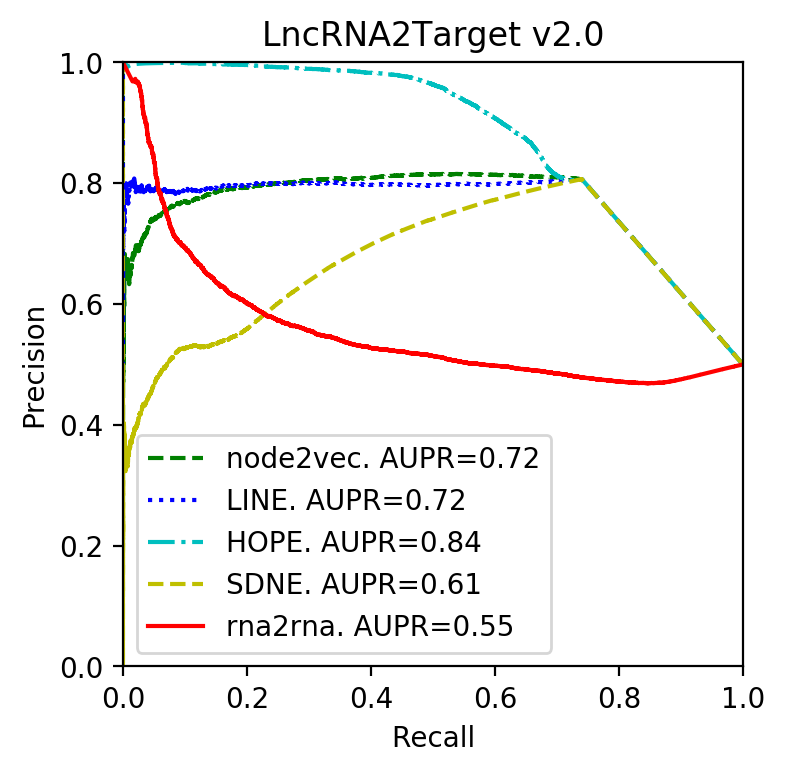

lncBase
Ed_count: 156149 , Eu_count: 0 , En_count: 0 , Ens_count 156149


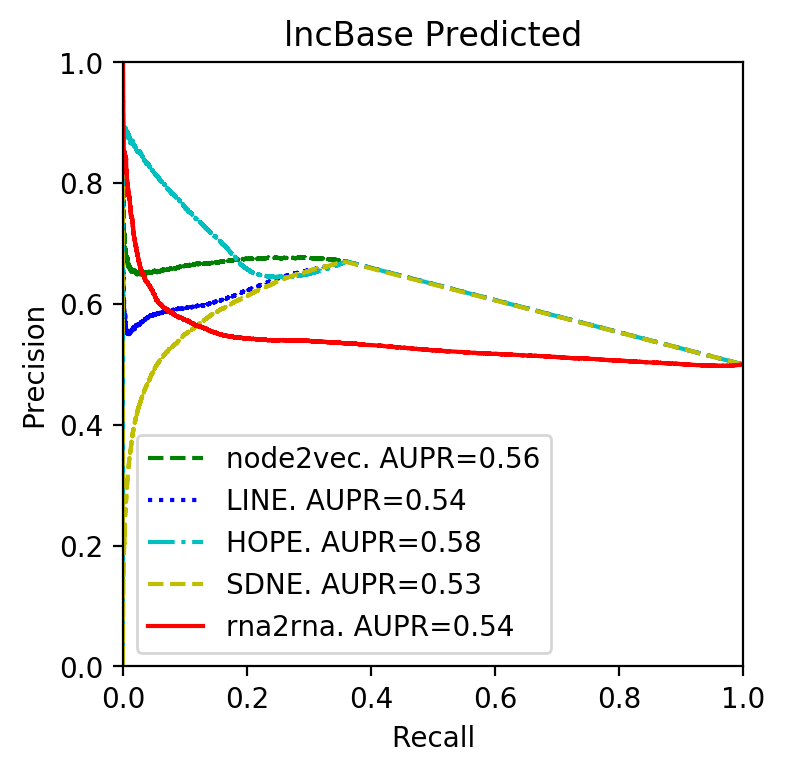

miRTarBase
Ed_count: 55891 , Eu_count: 0 , En_count: 0 , Ens_count 55891


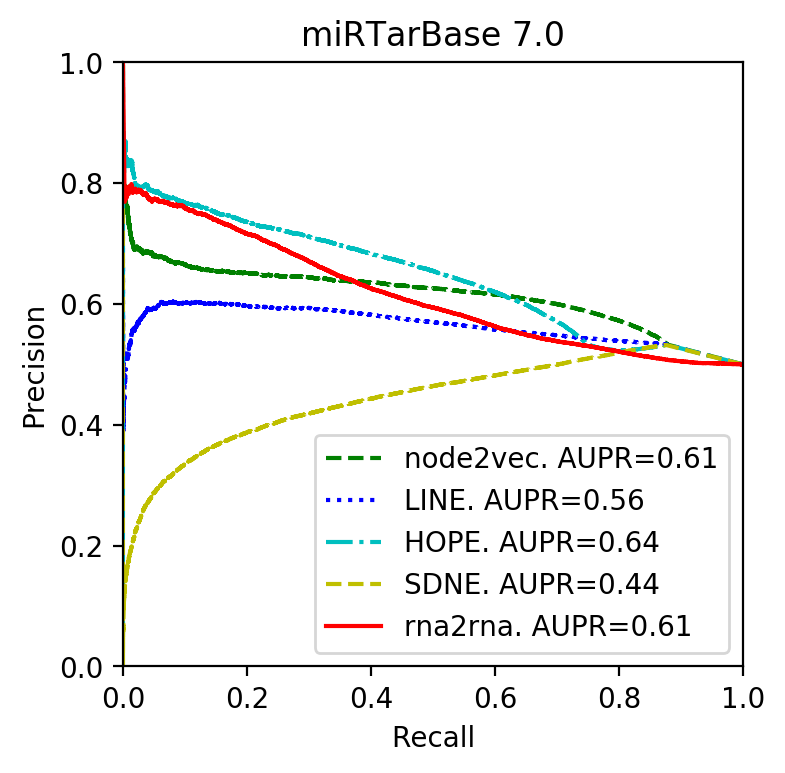

BioGRID


KeyboardInterrupt: 

Process ForkPoolWorker-1779:
Process ForkPoolWorker-1778:
Process ForkPoolWorker-1774:
Process ForkPoolWorker-1775:
Process ForkPoolWorker-1772:
Process ForkPoolWorker-1776:
Process ForkPoolWorker-1773:
Process ForkPoolWorker-1777:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/proc

In [27]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_val, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v2.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase Predicted"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 7.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.5"), 
                                            (None, None, "NPInter", "NPInter v3.0 "),
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])

In [ ]:
isolates = nx.isolates(network_val.G)
network_val.G.remove_nodes_from(list(isolates))
isolates = nx.isolates(network.G)
network.G.remove_nodes_from(list(isolates))
novel_nodes = list(set(network_val.G.nodes()) - set(network.G.nodes()))
print(len(novel_nodes), {modality:len(set(novel_nodes) & set(network.nodes[modality])) for modality in ["LNC", "MIR", "GE"]})
novel_edges = list(network_val.G.edges(novel_nodes, data=True))
print(len(novel_edges))
network_val.G.clear()
network_val.G.add_edges_from(novel_edges)

generator_val_novel = DataGenerator(network=network_val, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_network=network)
generator_val_novel.on_epoch_end()

In [ ]:
evaluate_pr_curve_link_pred_by_database(methods, generator_val_novel, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v1.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase v2"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 6.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.4"), 
                                            (None, None, "NPInter", "NPInter v2.0 "),
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.test_v2.pickle', 'rb') as file:
    network_val = pickle.load(file)

# Prepare Training set (for graph reconstruction)

In [ ]:
from moge.network.edge_generator import DataGenerator

generator_train = DataGenerator(network=network, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_train.Eu_count = 0
generator_train.En_count = 0
generator_train.on_epoch_end()

In [ ]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_train, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v1.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase v2"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 6.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.4"), 
                                            (None, None, "NPInter", "NPInter v2.0 "),
                                              ])

# Experimental Results

lncrna2target
nodes_A 2619
nodes_B 17114
estimated_adj (2619, 17114)
top_k_indices (array([ 800,  800,  800, ...,  800, 2022,  800]), array([ 5082, 13811, 15987, ...,  5113, 10131,  5568]))
nodes_A 2619
nodes_B 17114
estimated_adj (2619, 17114)
top_k_indices (array([2022, 2022,  348, ...,  187, 1905,  961]), array([ 9856,  4893,  6850, ...,  3537,  3176, 13160]))
nodes_A 2619
nodes_B 17114
estimated_adj (2619, 17114)
top_k_indices (array([1224, 1455, 1224, ..., 1790, 1224, 1455]), array([ 9879,  9879,  7504, ..., 13181, 10270, 13359]))
nodes_A 2619
nodes_B 17114
estimated_adj (2619, 17114)
top_k_indices (array([1190, 1134, 1134, ...,   72,  656,  790]), array([13671, 12784, 12783, ...,  1642,  1755,  1755]))
nodes_A 11647
nodes_B 19283
estimated_adj (11647, 19283)
top_k_indices (array([ 4428,  4428,  4428, ...,  4428,  4428, 11646]), array([17146, 18554, 18553, ..., 14295, 14286, 19282]))
nodes_A 11681
nodes_B 19283
estimated_adj (11681, 19283)
top_k_indices (array([10952, 10449, 10759

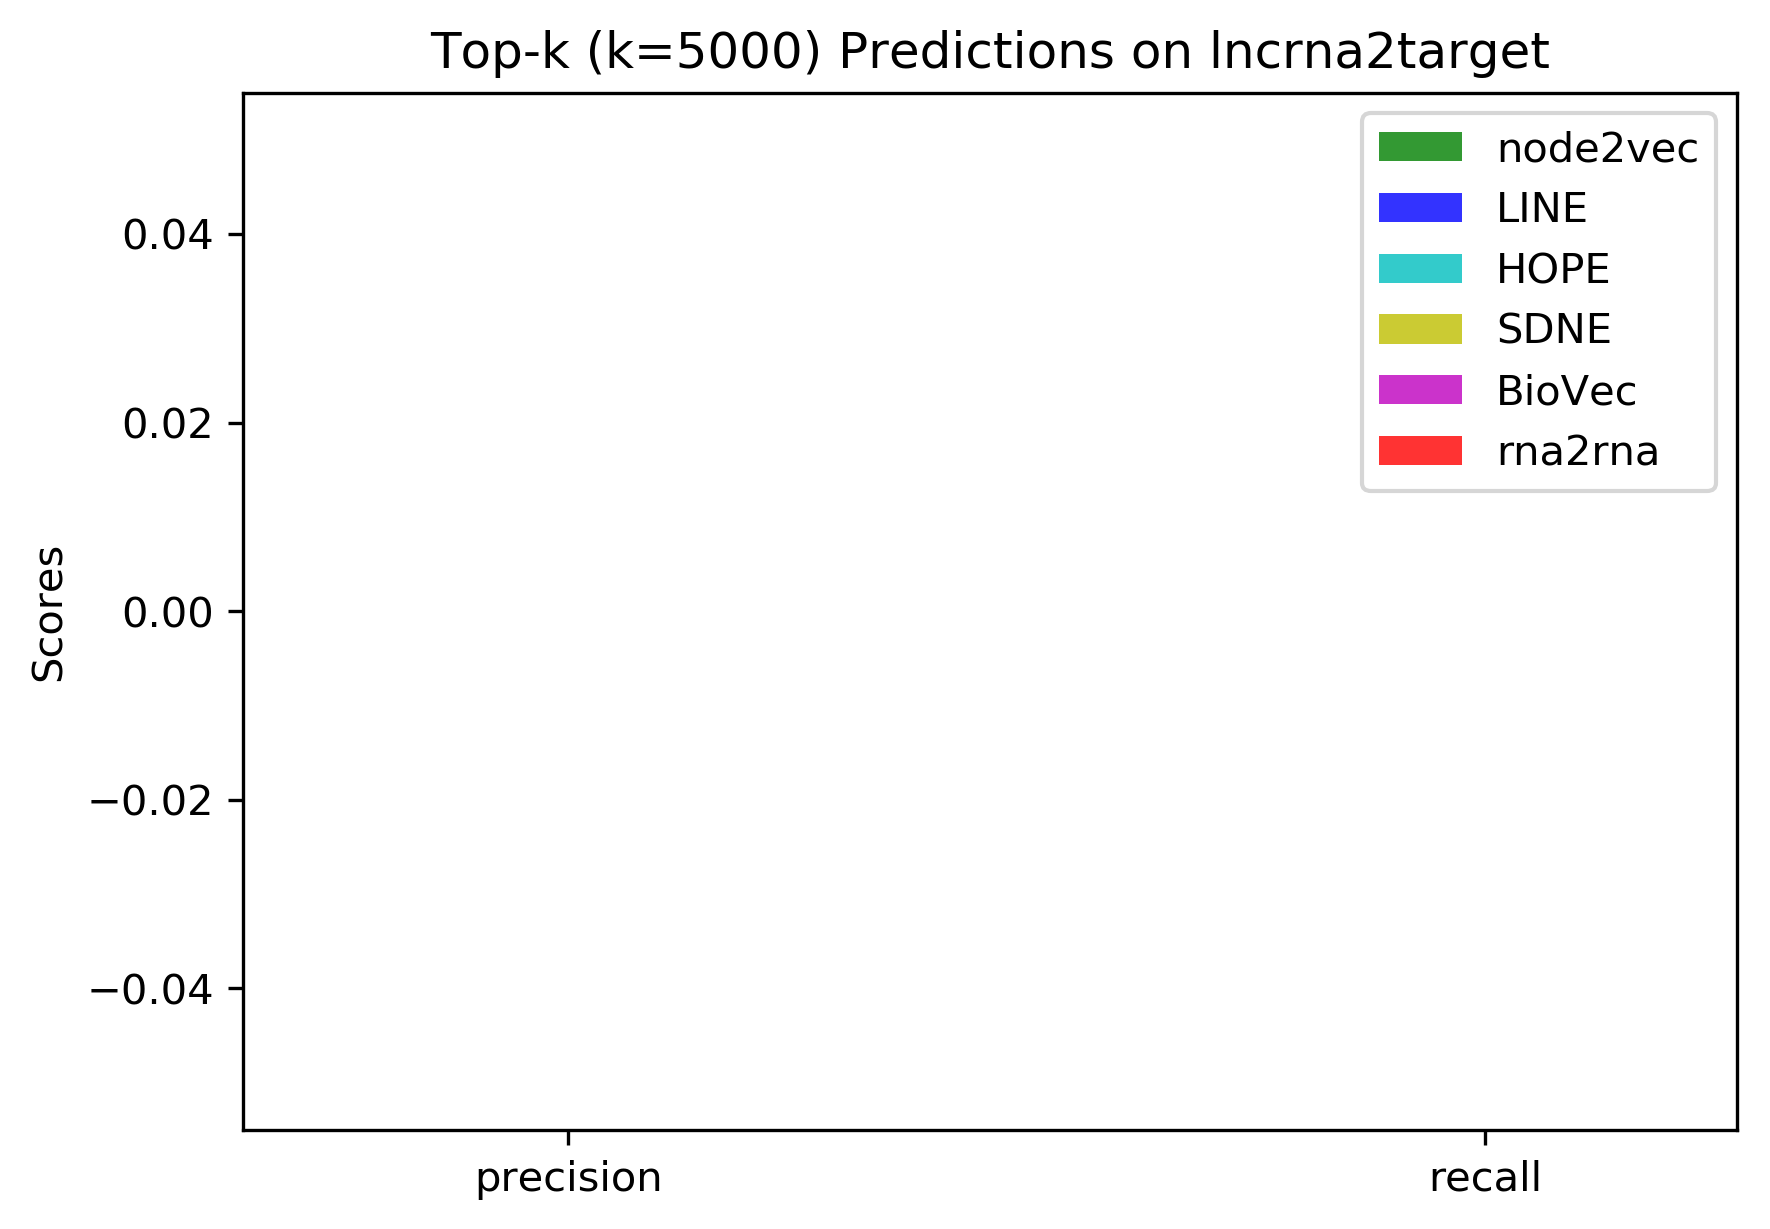

lncBase
nodes_A 1623
nodes_B 2619
estimated_adj (1623, 2619)
top_k_indices (array([   9,  648,   79, ...,  211, 1331, 1471]), array([ 185, 2482, 1124, ...,  570, 1898, 2144]))
nodes_A 1623
nodes_B 2619
estimated_adj (1623, 2619)
top_k_indices (array([  59,  637,  653, ...,   54, 1089,  913]), array([   0, 1405,    0, ...,  800, 1464,   54]))
nodes_A 1623
nodes_B 2619
estimated_adj (1623, 2619)
top_k_indices (array([ 155, 1606,    1, ...,  972,  697,   10]), array([   0,    0,    0, ...,  440, 1455, 1477]))
nodes_A 1623
nodes_B 2619
estimated_adj (1623, 2619)
top_k_indices (array([ 59, 205, 205, ..., 412, 412, 412]), array([   0,   90,  596, ..., 1396, 1085, 1337]))
nodes_A 1778
nodes_B 11647
estimated_adj (1778, 11647)
top_k_indices (array([ 593,  593,  593, ...,  593,  593, 1777]), array([ 4743,  3089,  3090, ...,  5664,  5671, 11646]))
nodes_A 1778
nodes_B 11681
estimated_adj (1778, 11681)
top_k_indices (array([1605,  254, 1148, ...,  294, 1375, 1224]), array([ 8070,  9441, 11511, ..

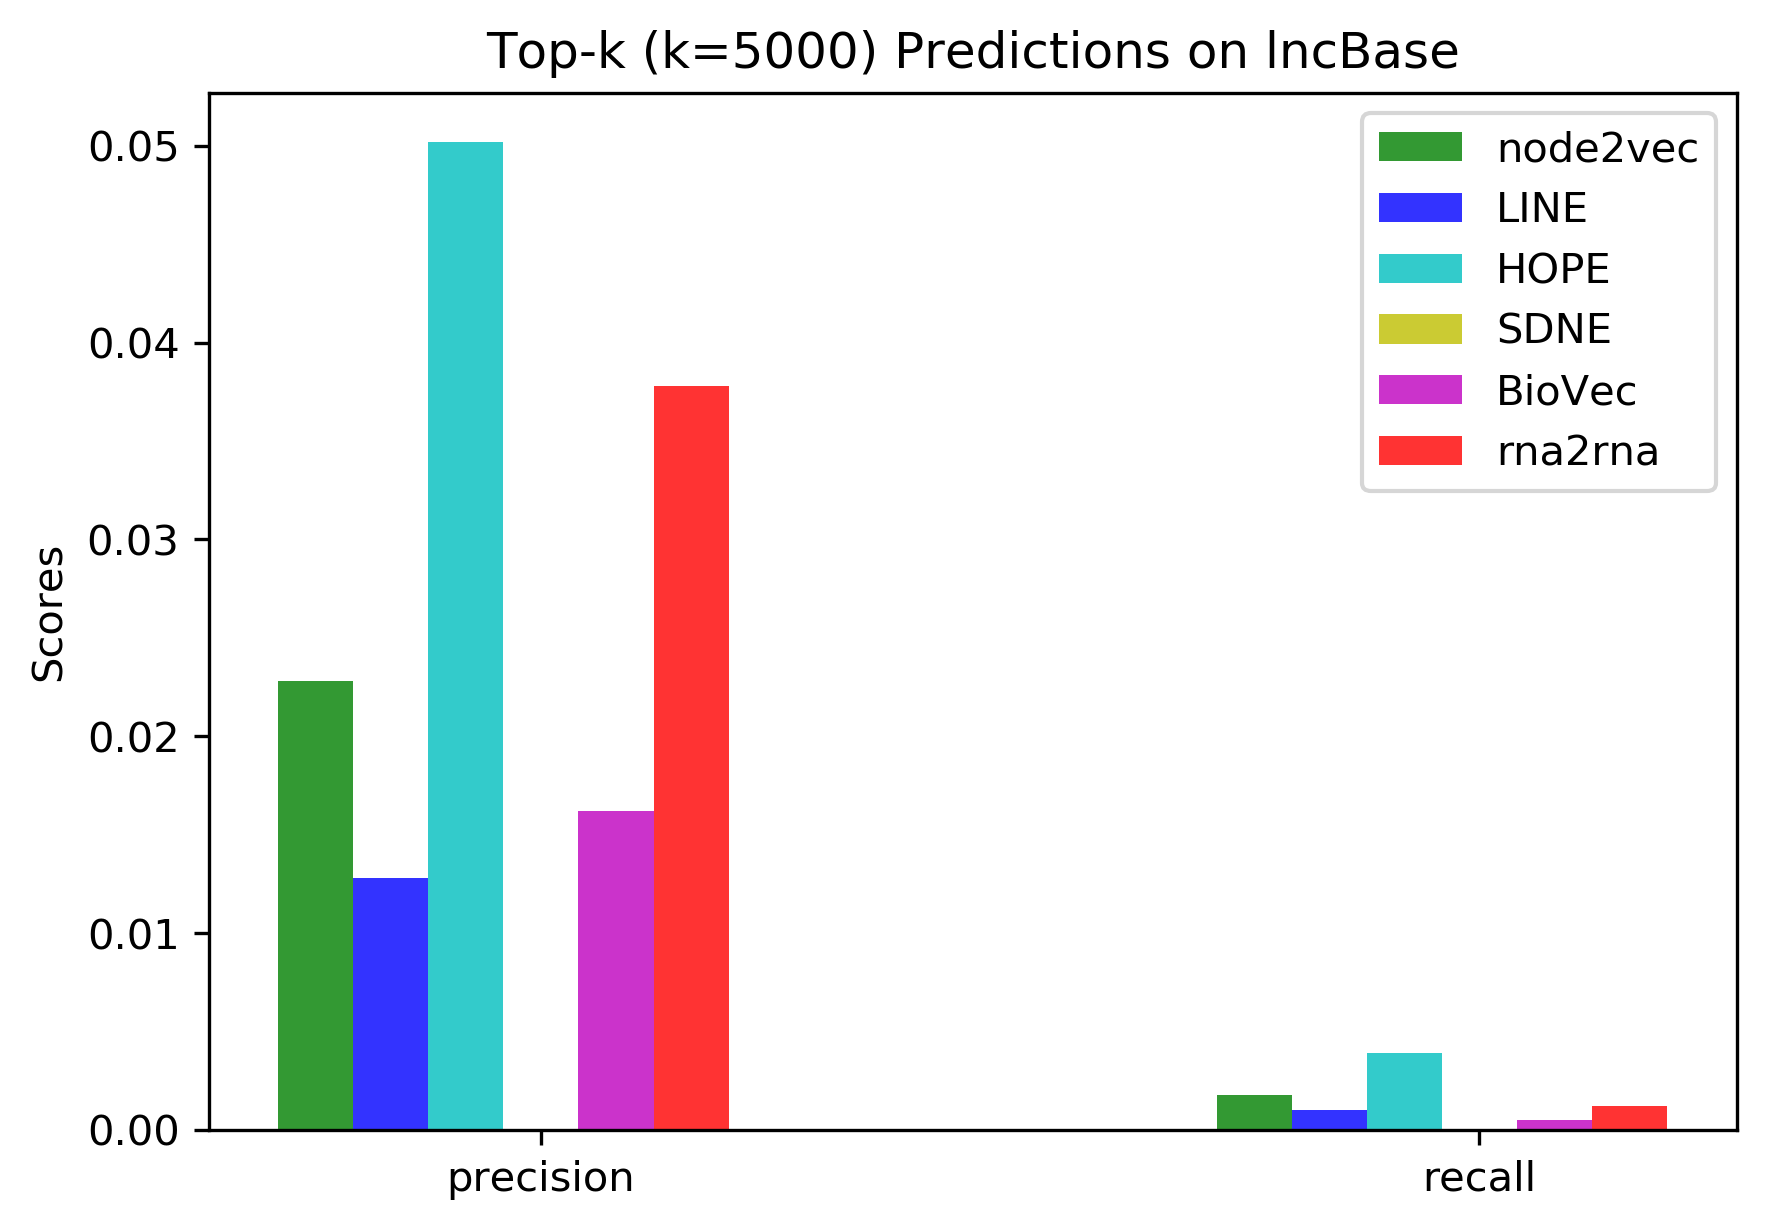

miRTarBase
nodes_A 1623
nodes_B 17114
estimated_adj (1623, 17114)
top_k_indices (array([ 497,  494,  549, ...,    3, 1277, 1420]), array([ 677,  677,  677, ..., 8077, 2046, 6850]))
nodes_A 1623
nodes_B 17114
estimated_adj (1623, 17114)
top_k_indices (array([1392, 1084, 1084, ...,  603,  564,   72]), array([ 9996, 12203, 16194, ..., 15371, 13476,  9107]))
nodes_A 1623
nodes_B 17114
estimated_adj (1623, 17114)
top_k_indices (array([  1,   1, 270, ..., 656, 398, 339]), array([15371,  9836,   794, ...,  4396,  3128,  4396]))
nodes_A 1623
nodes_B 17114
estimated_adj (1623, 17114)
top_k_indices (array([ 48, 205, 205, ..., 772, 772, 160]), array([  296, 10938,  5615, ..., 14000, 10085,  8758]))
nodes_A 1778
nodes_B 19283


KeyboardInterrupt: 

In [54]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

database_tests = [
    ("LNC", "GE", "lncrna2target"),
    ("MIR", "LNC", "lncBase"),
    ("MIR", "GE", "miRTarBase"), 
    ("GE", "GE", "BioGRID"), 
    ("LNC", "GE", "lncRInter"),
    # ("LNC", "GE", "LncReg"),
]
top_k = 5000

for source, target, database in database_tests:
    print(database)
    results = {}
    for method in methods.keys():
        results[method] = \
              evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                                       node_list=set(network.nodes[source])|set(network_val.nodes[source]), 
                                       node_list_B=set(network.nodes[target])|set(network_val.nodes[target]), 
                                       edge_type="d", databases=[database], top_k=top_k)
        
    bar_chart(results, measures=['precision', 'recall'], 
              title="Top-k (k={}) Predictions on {}".format(top_k, database))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="locus_type", 
                                          max_clusters=500, n_clusters=None)

bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'],
         title="Clustering Evaluation to {}".format("RNA Type"))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="Family", 
                                          max_clusters=500, n_clusters=None)
    
bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'], 
          title="Clustering Evaluation to {}".format("RNA Family"))

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Family", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Disease association", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.utils import get_scalefree_fit_score

results = {}
modalities = [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]
labels = ["miRNA-lncRNA", "lncRNA-miRNA", "lncRNA-mRNA", "miRNA-mRNA", "mRNA-mRNA"]
databases = ["lncBase", "NPInter", "lncrna2target", "miRTarBase", "BioGRID"]

for method in ["Databases"]+list(methods.keys()):
    if method == "BioVec":
        continue
    elif method == "Databases":
        sub_result = {}
        for (A, B), label, database in zip(modalities, labels, databases):
            adj = network.get_adjacency_matrix(edge_types=["d"], 
                                               node_list=network.node_list,
                                               databases=[database,])
            network_degrees = np.sum(adj, axis=1)
            sub_result[label] = get_scalefree_fit_score(network_degrees, plot=False)
        results[method] = sub_result
    else:
        sub_result = {}
        for (A, B), label in zip(modalities, labels):
           sub_result[label] = methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B])
        results[method] = sub_result
    
bar_chart(results, measures=labels, title="Scale-free fit scores", loc="lower right")

# Visualize lncRNA Subgraphs

In [31]:
modalities = [("MIR", "LNC", "lncBase"), 
              ("LNC", "MIR", "NPInter"), 
              ("LNC", "GE", "lncrna2target"), 
              ("MIR", "GE", "miRTarBase"), 
              ("GE", "GE", "BioGRID")
             ]

nodes_inters_dict = {}
for A, B, database in modalities:
    edge_list = [(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]==database and\
                u in network.nodes[A] and v in network.nodes[B]]
    nodes_inters_dict[(A, B)] = {}
    nodes_inters_dict[(A, B)][A] = {u for u,v,d in edge_list}
    nodes_inters_dict[(A, B)][B] = {v for u,v,d in edge_list}

In [32]:
nodes_inters_dict_2 = dict.fromkeys(rna2rna_emb.node_list, 0)

for A, B, database in modalities:
    if database == "BioGRID": continue
    for node in nodes_inters_dict[(A, B)][A]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
    for node in nodes_inters_dict[(A, B)][B]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
        
trimodule_nodes = [k for k,v in nodes_inters_dict_2.items() if (k in network.nodes["LNC"] and v >= 2) or \
                   (k in network.nodes["MIR"] and v >= 2) or \
                  (k in network.nodes["GE"] and v >= 2)]
[(m, len(set(trimodule_nodes) & set(network.nodes[m]))) for m in ["LNC", "MIR", "GE"]]

[('LNC', 248), ('MIR', 909), ('GE', 8718)]

In [33]:
set(trimodule_nodes) & set(network.nodes["LNC"])

{'A1BG-AS1',
 'AC005498.3',
 'AC006947.1',
 'AC007620.3',
 'AC009264.1',
 'AC009299.3',
 'AC010980.2',
 'AC012368.1',
 'AC017074.2',
 'AC020663.1',
 'AC025171.1',
 'AC027601.1',
 'AC099850.1',
 'AC131097.3',
 'AC132872.1',
 'AC156455.1',
 'ADPGK-AS1',
 'AFAP1-AS1',
 'AGAP1-IT1',
 'ALMS1-IT1',
 'ANKRD10-IT1',
 'ANKRD44-IT1',
 'AP000265.1',
 'AP001372.2',
 'ARHGAP22-IT1',
 'ASH1L-AS1',
 'ASMTL-AS1',
 'ATP6V0E2-AS1',
 'ATXN8OS',
 'BACH1-IT1',
 'BCDIN3D-AS1',
 'BHLHE40-AS1',
 'BOLA3-AS1',
 'CACTIN-AS1',
 'CASC15',
 'CASC2',
 'CBR3-AS1',
 'CDKN2B-AS1',
 'COX10-AS1',
 'CRNDE',
 'CTC-338M12.4',
 'CYTOR',
 'DACT3-AS1',
 'DANCR',
 'DAPK1-IT1',
 'DHRS4-AS1',
 'DICER1-AS1',
 'DIO3OS',
 'DLEU2',
 'DLGAP1-AS5',
 'EMX2OS',
 'ENTPD1-AS1',
 'EPB41L4A-AS1',
 'ERI3-IT1',
 'ERVK13-1',
 'FAM13A-AS1',
 'FAM87B',
 'FENDRR',
 'FGD5-AS1',
 'FLG-AS1',
 'FOXD2-AS1',
 'FOXP1-IT1',
 'FTX',
 'GABPB1-AS1',
 'GAS5',
 'GHRLOS',
 'GNAS-AS1',
 'GS1-124K5.4',
 'H19',
 'H1FX-AS1',
 'HAGLR',
 'HCFC1-AS1',
 'HCG11',
 'HCG1

In [51]:
g = network.G.subgraph(trimodule_nodes).to_undirected()
center_node = "HOTAIR"
nodelist = list(g.neighbors(center_node))+[center_node]
len(nodelist)

71

In [52]:
predicted_edges = siamese.get_top_k_predicted_edges(edge_type="d", top_k=50, 
                                  node_list=[center_node],
                                  node_list_B=network.node_list,
                                  training_network=network,)
predicted_edges[:n_pred_edges]

nodes_A 1
nodes_B 32741
estimated_adj (1, 32741)
top_k_indices (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]), array([10367, 15093,  9494, 15633, 19183, 12608,  6801, 15945,  8758,
        7235,  7154, 15690,  7488,  8819, 20355,  4326, 19771,  8544,
        1982, 16923,  6024,  6300,  6928, 12047,  4077, 10969,  7938,
        6660, 15600, 14673, 15692,  8012, 18569, 13835, 10675, 14676,
        9346,  3304, 10949, 20577, 16185,  8759, 17855,  2757, 30908,
       17743,  9936,  2075,  8729,  3903]))


[('HOTAIR', 'LECT2', 0.9999788),
 ('HOTAIR', 'RASSF8', 0.99996555),
 ('HOTAIR', 'IQGAP1', 0.9999627),
 ('HOTAIR', 'RPL27A', 0.999962),
 ('HOTAIR', 'TRIM28', 0.9999554),
 ('HOTAIR', 'NUS1', 0.9999536),
 ('HOTAIR', 'ERCC3', 0.99995244),
 ('HOTAIR', 'SATB1', 0.9999484),
 ('HOTAIR', 'HIST1H1C', 0.9999424),
 ('HOTAIR', 'FAR1', 0.9999366),
 ('HOTAIR', 'FAM43A', 0.9999268),
 ('HOTAIR', 'RPS15A', 0.99992585),
 ('HOTAIR', 'FKBP7', 0.9999249),
 ('HOTAIR', 'HIST3H2A', 0.9999224),
 ('HOTAIR', 'ZC3H8', 0.999918),
 ('HOTAIR', 'CCT6B', 0.9999156),
 ('HOTAIR', 'USHBP1', 0.9999126),
 ('HOTAIR', 'H2AFY2', 0.9999105),
 ('HOTAIR', 'ACTB', 0.9999095),
 ('HOTAIR', 'SMARCA5', 0.9999058),
 ('HOTAIR', 'DHX15', 0.9999057),
 ('HOTAIR', 'DRAP1', 0.99990344),
 ('HOTAIR', 'EXPH5', 0.9999031),
 ('HOTAIR', 'NDUFA8', 0.9998876),
 ('HOTAIR', 'CBLN4', 0.9998872),
 ('HOTAIR', 'MAPK9', 0.9998869),
 ('HOTAIR', 'GET4', 0.9998789),
 ('HOTAIR', 'EMC1', 0.9998747),
 ('HOTAIR', 'RPL10A', 0.9998746),
 ('HOTAIR', 'PSMC2', 0.99987

In [58]:
n_pred_edges = 10
predicted_edges_filter = [(u,v) for u,v,d in predicted_edges[:n_pred_edges]]
nodelist = list(set(nodelist) | {node for pair in predicted_edges_filter for node in pair})
true_edges = network.get_edgelist(node_list=nodelist, inclusive=True)
edgelist = true_edges + predicted_edges_filter
edge_colors = [10,]*len(true_edges) + [0,]*len(predicted_edges_filter)
linewidths = [0.4,]*len(true_edges) + [1.2,]*len(predicted_edges_filter)
print(len(edgelist), len(edge_colors))

399 399


In [59]:
layout = nx.spring_layout(network.G.subgraph(nodelist), 
#                           weight='weight',
                          k=15.0/len(nodelist)**0.5,
                          iterations=100)

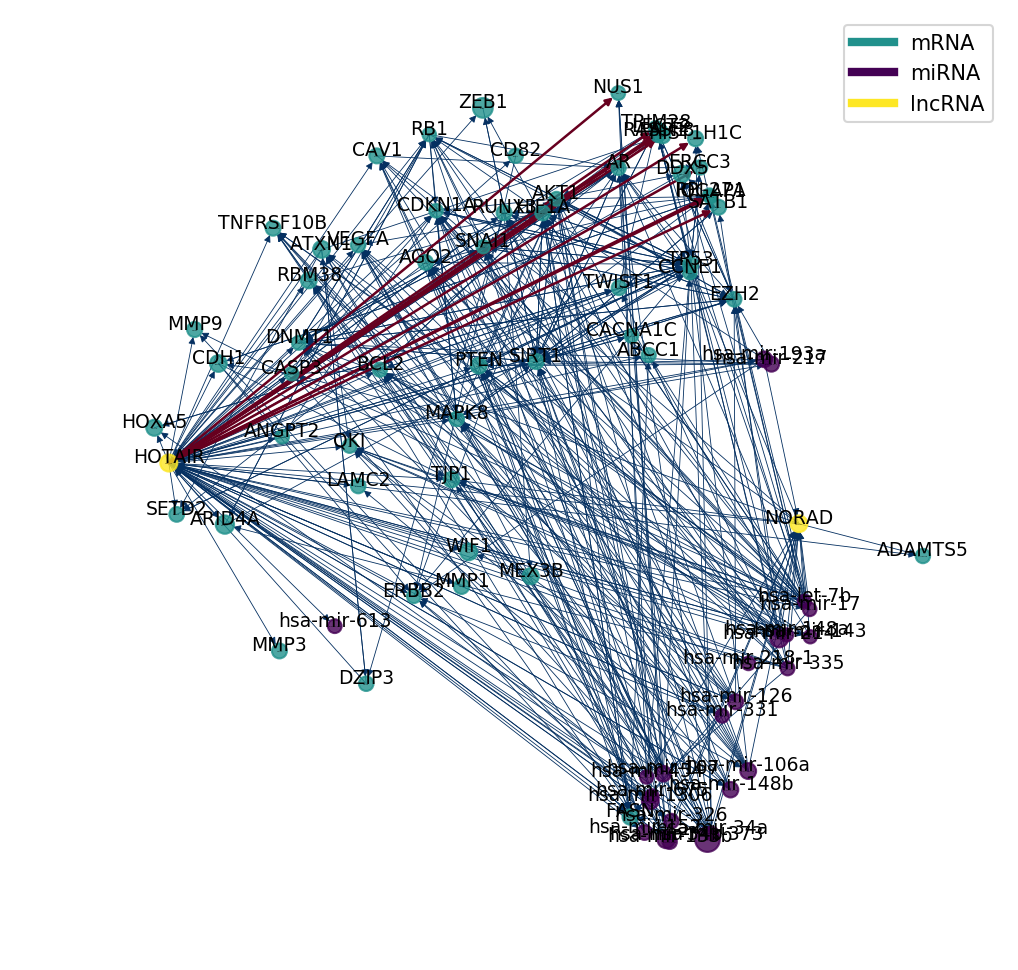

<Figure size 432x288 with 0 Axes>

In [60]:
# siamese.process_embeddings(variable_length=True, minlen=200)
# delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, 
                    nodelist=nodelist,
                    node_label="RNA Type",
                    figsize=(8,8), dpi=150,
                    node_size="centrality", 
                    edgelist=edgelist, width=linewidths,
                    edge_color=edge_colors, edge_cmap=plt.cm.RdBu, 
                    with_labels=True, font_size=0, labels=None, arrowsize=7,
                    cmap="viridis",
                    file_name="moge/data/Results/vis_lncRNAs/{}".format(center_node),)

# Visualize RNA Embeddings

In [ ]:
visualize_embedding(rna2rna_emb, network=network, 
                    nodelist=nodelist,
                    node_label="locus_type", # sc.tolist(), 
                    top_k=0,
                    edgelist=network.get_edgelist(node_list=nodelist, inclusive=True),
#                     test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="gist_ncar",
                    node_size="centrality", 
                    with_labels=True, font_size=0, labels=None, arrowsize=9,
                    figsize=(10,10), dpi=150,
#                     file_name="moge/data/Results/siamese_online_triplet_euclidean",
                   )

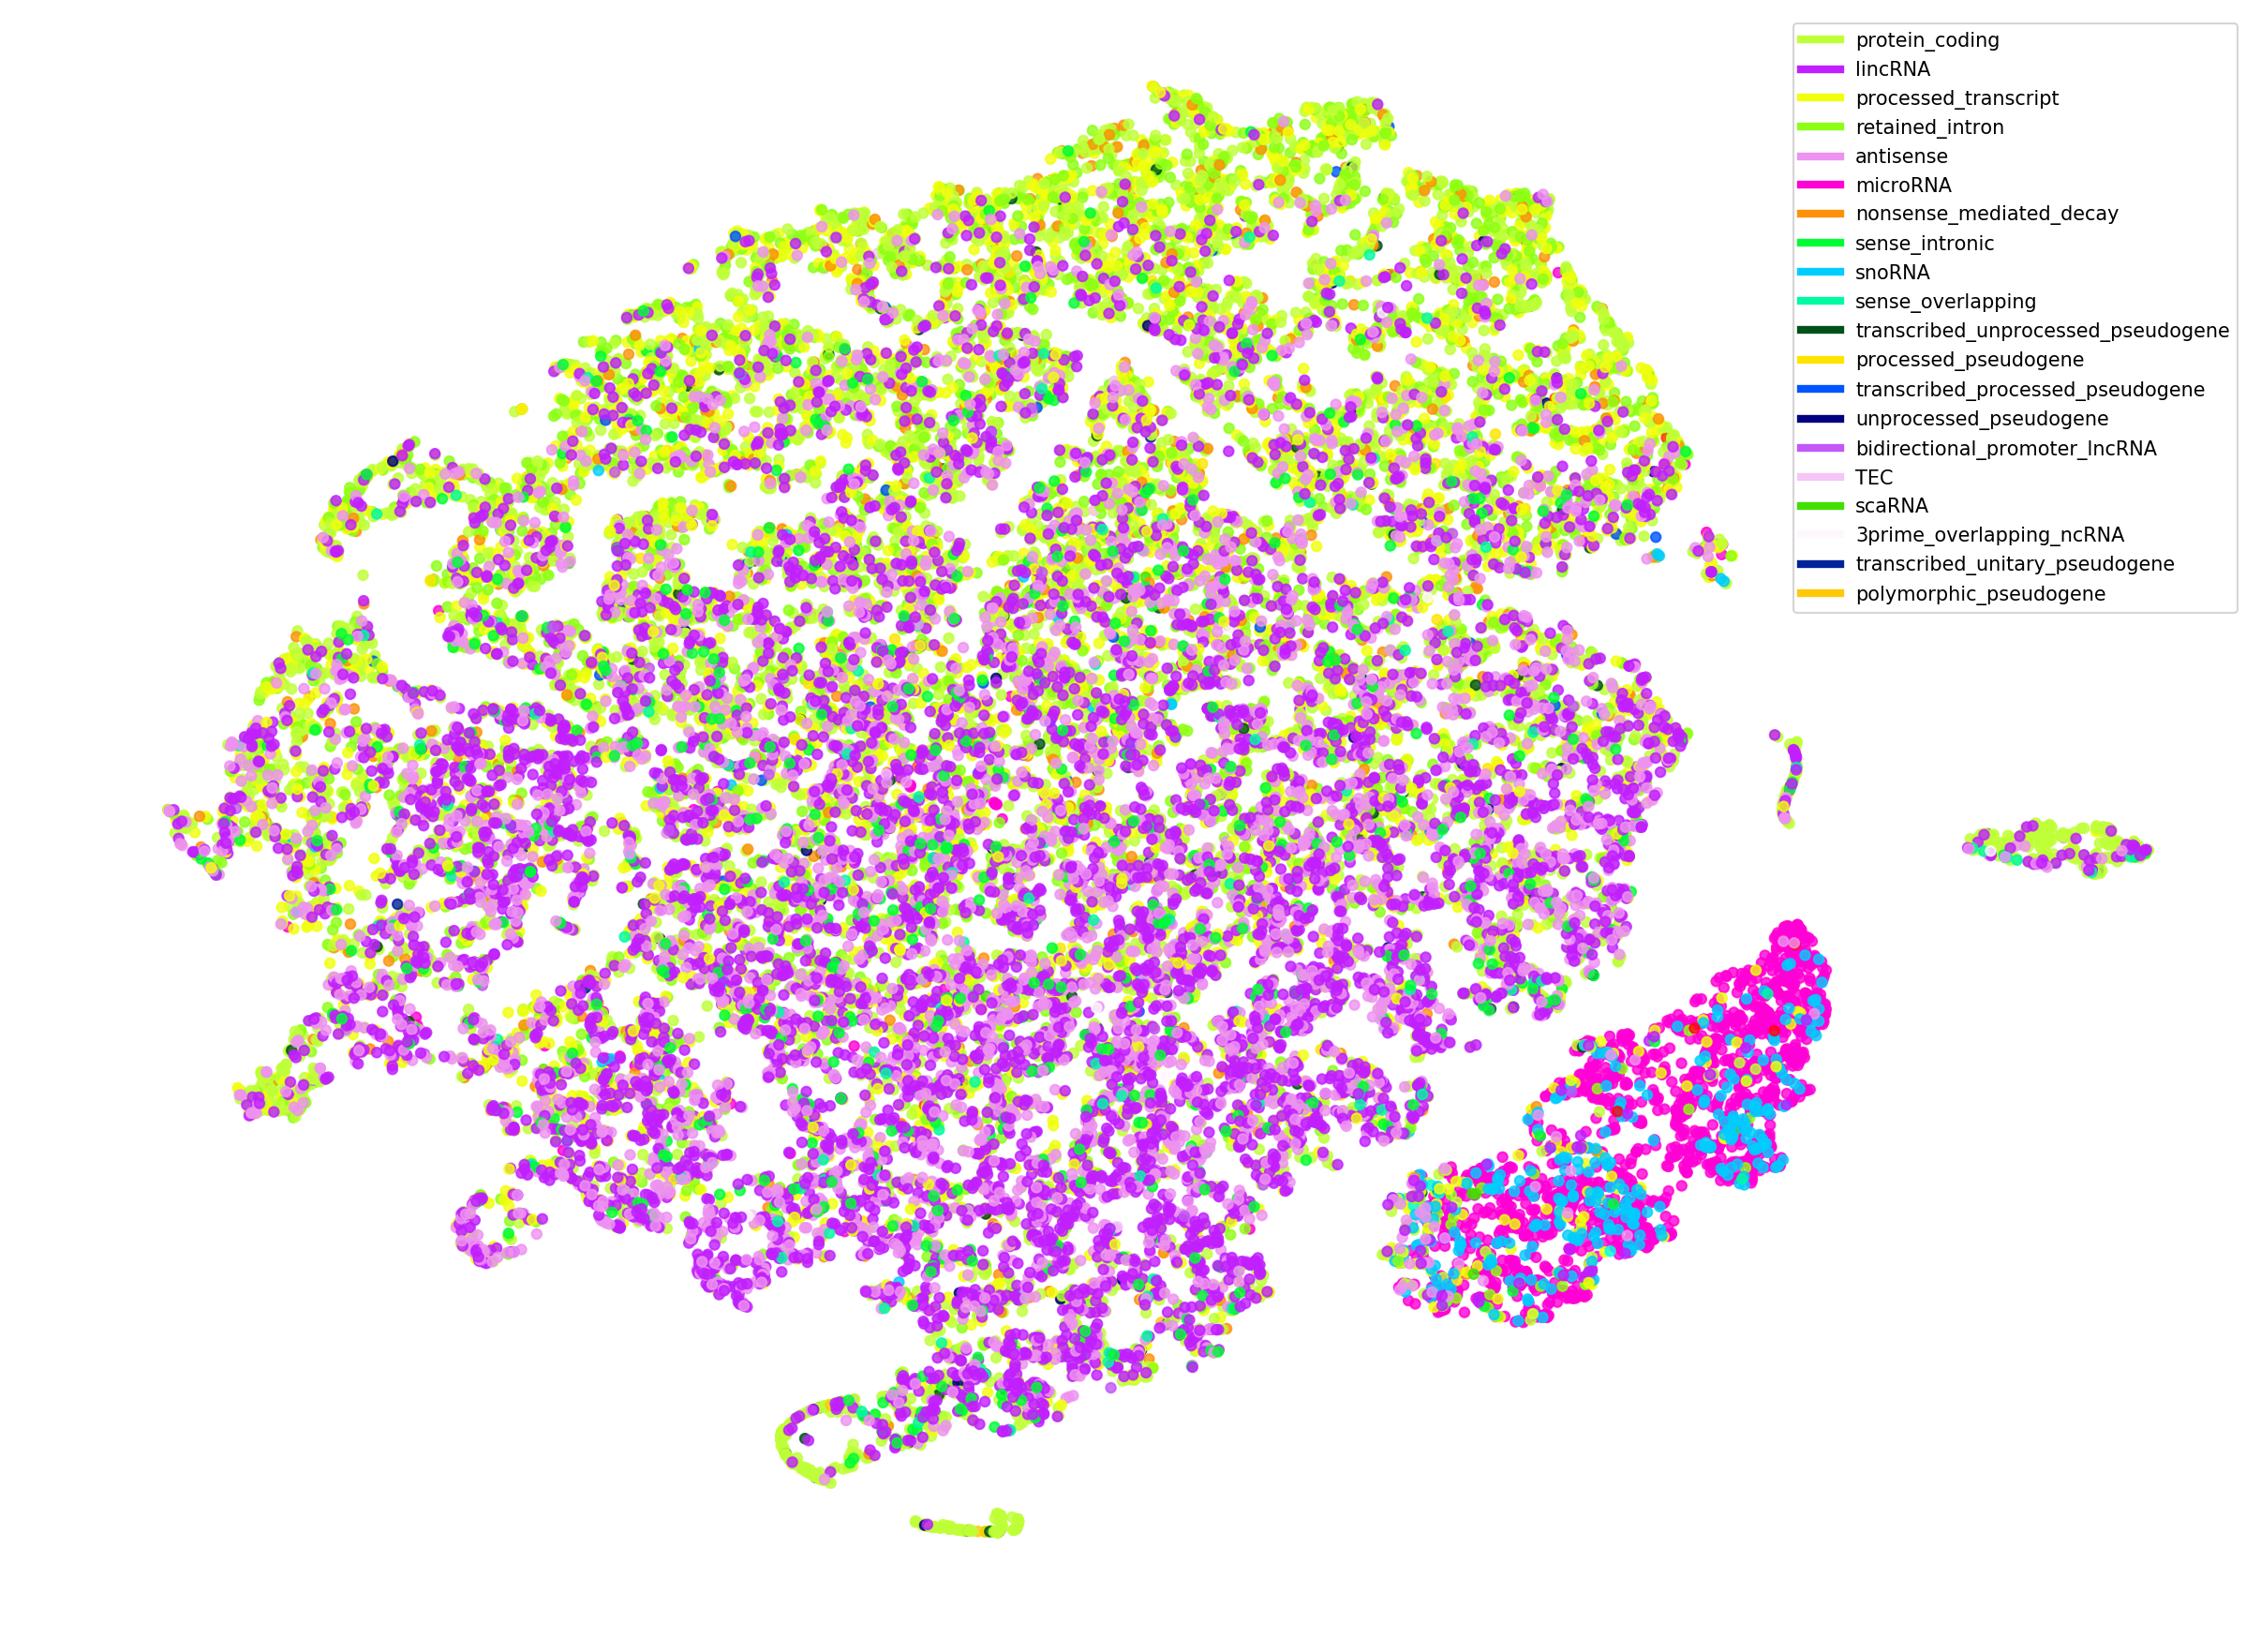

In [61]:
# siamese.process_embeddings(variable_length=True, minlen=200)
# delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, node_label="locus_type", 
#                     edgelist=network_val.get_edgelist(node_list=nodes_to_visualize, 
#                                                       edge_types=["d"])[:500],
#                     test_nodes=nodes_test,
                    cmap="gist_ncar",)

In [ ]:
# nx.write_edgelist(network.G.subgraph(nodelist), "./moge/data/Networks/{}.edgelist".format(center_node))

In [ ]:
plot_bokeh_graph(network.G.subgraph(nodelist), node_pos=layout,
                 node_label=network.genes_info.loc[nodelist, "locus_type"].values.tolist())

# AUC Rate

%%javascript
Jupyter.notebook.session.delete();